In [32]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd

## Нужная переменная zos (sea_surface_height_above_geoid)

In [33]:
nemo_data_folder='./dataset_SPITZ12'
test_file=os.path.join(nemo_data_folder, os.listdir(nemo_data_folder)[0])
ds = nc.Dataset(test_file)
#for var in ds.variables.values():
    #print(var)
print(np.array(ds['zos']).shape)

(1, 115, 117)


## Извлечение индекса ячейки по координатам

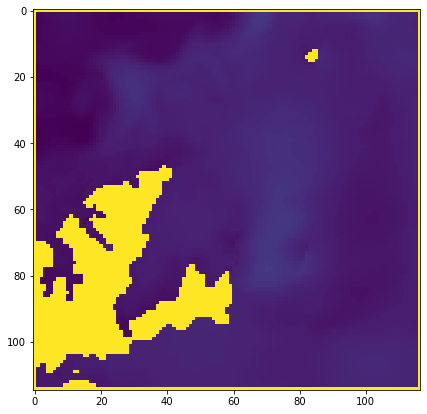

In [34]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ds['zos'])[0])
# как выглядит наша переменная

In [35]:
def idx_by_2coord(coordinate, lat_array, lon_array):
    # делаем один двумерный массив, в котором каждая ячейка содержит и широту и долготу
    coord_array=np.concatenate((np.array([np.ravel(lat_array)]).T, np.array([np.ravel(lon_array)]).T), axis=1)
    # переворачиваем его к исходной форме
    coord_array=np.reshape(coord_array, (lat_array.shape[0],lat_array.shape[1], 2))
    # вычитаем из каждой координаты нашу координату
    dif=np.abs(coord_array-coordinate)
    # суммируем модули отклонения по обеим координатам
    dis=np.sum(dif, axis=2)
    
    #plt.imshow(dis) # центр "крестика" и есть наша точка
    
    # извлекаем индекс центра "крестика"
    geo_idx = np.unravel_index(dis.argmin(), dis.shape)
    return geo_idx

In [36]:
idx_by_2coord([75.295924, 18.454331], np.array(ds['nav_lat']), np.array(ds['nav_lon']))

(28, 68)

### *NEMO запустила на отдельный день в отдельном файле* 

## Формируем словарь

In [37]:
coordinates_from_map={'lat':[75.532663, 76.006222, 75.210923],
                      'lon':[17.902096, 24.893752, 11.252254]}

dates_list=[]
names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
print(names_dict)

for file in os.listdir(nemo_data_folder):
    #print(file)        
    try:
        ds = nc.Dataset(os.path.join(nemo_data_folder, file))
    except Exception as e:
        print(e)
        pass
    if file.split('_')[3]=='00020101':
        prefix='2003'
    else:
        prefix='2002'
    date=prefix+file.split('_')[-1].split('-')[-2][4:]
    
    dates_list.append(date)
        
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['zos'][:, :, :])[0]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = np.array(ds['nav_lat'])
        lons = np.array(ds['nav_lon'])

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
names_dict['dates']=dates_list

{'75.532663_17.902096': [], '76.006222_24.893752': [], '75.210923_11.252254': []}


## Датафрейм с временными рядами

In [38]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
pd_df['dates'] =  pd.to_datetime(pd_df['dates'], format='%Y%m%d')
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./timelines_data/formed_timelines_2002_2003/2002-2003_spitz_nemo.csv', sep=';', index=False)
pd_df

,75.532663_17.902096,76.006222_24.893752,75.210923_11.252254,dates
0,-0.866979,-0.890416,-0.945982,2002-01-01
1,-0.907407,-0.904165,-0.967084,2002-01-02
2,-0.899823,-0.924889,-0.946681,2002-01-03
3,-0.888992,-0.878961,-0.923555,2002-01-04
4,-0.879334,-0.882886,-0.898750,2002-01-05
...,...,...,...,...
725,-0.813633,-0.794234,-0.898294,2003-12-27
726,-0.819116,-0.797382,-0.909647,2003-12-28
727,-0.832524,-0.796991,-0.920079,2003-12-29
728,-0.841049,-0.806349,-0.929752,2003-12-30


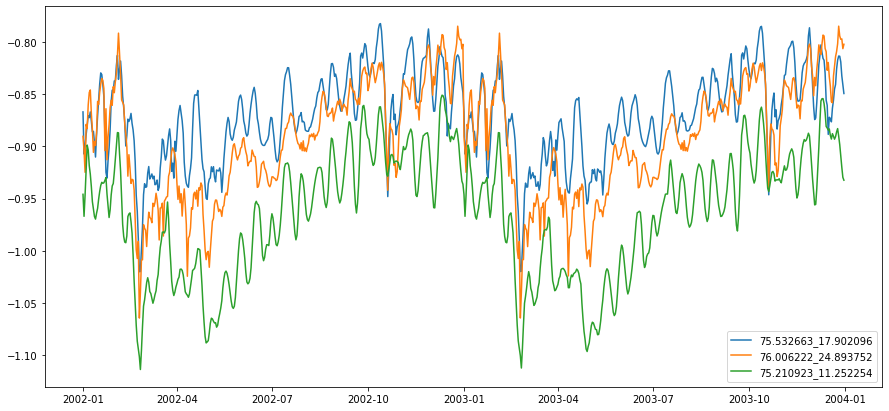

In [39]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)
plt.legend()
plt.show()